In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, average_precision_score,
                             f1_score, precision_score, recall_score, jaccard_score, roc_auc_score)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

plt.style.use('bmh')

In [2]:
data = pd.read_csv('credit_card_fraud.csv')
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print("Imbalanced labels")

data.Class.value_counts(normalize=True)

Imbalanced labels


0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
X = data.copy(deep=True)
y = X.pop('Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

In [5]:
print("*** Train ***")
print(y_train.shape)
print(y_train.value_counts(normalize=True))

print('-'*50)

print("*** Test ***")
print(y_test.shape)
print(y_test.value_counts(normalize=True))


*** Train ***
(199364,)
0    0.998275
1    0.001725
Name: Class, dtype: float64
--------------------------------------------------
*** Test ***
(85443,)
0    0.998268
1    0.001732
Name: Class, dtype: float64


In [6]:
def get_classification_scores(estimator, X, y):
    y_pred = estimator.predict(X)
    y_score = estimator.predict_proba(X)[:,1]
    
    acc = accuracy_score(y, y_pred)
    bal_acc = balanced_accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    avg_precision = average_precision_score(y, y_score)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_score)
    jaccard = jaccard_score(y, y_pred)
    
    stats = {'Accuracy':acc, 
             'Balanced Accuracy':bal_acc,
             'Precision':precision,
             'Recall':recall,
             'Average Precision':avg_precision,
             'F1':f1,
             'ROC AUC':roc_auc,
             'Jaccard':jaccard}
    
    return stats

In [7]:
forest = RandomForestClassifier(random_state=123, warm_start=False, verbose=0, n_jobs=-1)
performance_scores = {}

In [8]:
# baseline

print('*** Original labels ***')
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
forest_base = forest.fit(X_train, y_train)
performance_scores['baseline'] = get_classification_scores(forest_base, X_test, y_test)

*** Original labels ***
0    199020
1       344
Name: Class, dtype: int64
0    0.998275
1    0.001725
Name: Class, dtype: float64


In [9]:
# random under-sampling

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print('*** RandomUnderSampler labels ***')
print(y_rus.value_counts())
print(y_rus.value_counts(normalize=True))
forest_rus = forest.fit(X_rus, y_rus)
performance_scores['underSampled'] = get_classification_scores(forest_rus, X_test, y_test)

*** RandomUnderSampler labels ***
0    344
1    344
Name: Class, dtype: int64
0    0.5
1    0.5
Name: Class, dtype: float64


In [10]:
# random over-sampling

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print('*** RandomOverSampler labels ***')
print(y_ros.value_counts())
print(y_ros.value_counts(normalize=True))
forest_ros = forest.fit(X_ros, y_ros)
performance_scores['overSampled'] = get_classification_scores(forest_ros, X_test, y_test)

*** RandomOverSampler labels ***
0    199020
1    199020
Name: Class, dtype: int64
0    0.5
1    0.5
Name: Class, dtype: float64


In [11]:
# SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print('*** SMOTE labels ***')
print(y_smote.value_counts())
print(y_smote.value_counts(normalize=True))
forest_smote = forest.fit(X_smote, y_smote)
performance_scores['SMOTE'] = get_classification_scores(forest_smote, X_test, y_test)

*** SMOTE labels ***
0    199020
1    199020
Name: Class, dtype: int64
0    0.5
1    0.5
Name: Class, dtype: float64


In [12]:
# ADASYN

adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
print('*** ADASYN labels ***')
print(y_adasyn.value_counts())
print(y_adasyn.value_counts(normalize=True))
forest_adasyn = forest.fit(X_adasyn, y_adasyn)
performance_scores['ADASYN'] = get_classification_scores(forest_adasyn, X_test, y_test)

*** ADASYN labels ***
1    199094
0    199020
Name: Class, dtype: int64
1    0.500093
0    0.499907
Name: Class, dtype: float64


In [13]:
# class_weight = 'balanced'

forest_balanced = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
forest_balanced.fit(X_train, y_train)
performance_scores['balancedClassWeight'] = get_classification_scores(forest_balanced, X_test, y_test)

In [14]:
# imblearn BalancedRandomForestClassifier

balanced_rf = BalancedRandomForestClassifier(n_jobs=-1)
balanced_rf.fit(X_train, y_train)
performance_scores['balancedRF'] = get_classification_scores(balanced_rf, X_test, y_test) 

In [15]:
# imblearn BalancedRandomForestClassifier with class_weight = 'balanced'

balanced_rf_cw = BalancedRandomForestClassifier(class_weight='balanced', n_jobs=-1)
balanced_rf_cw.fit(X_train, y_train)
performance_scores['balancedRFClassWeight'] = get_classification_scores(balanced_rf_cw, X_test, y_test)

In [16]:
perf_df = pd.DataFrame(performance_scores)
perf_df.T

,Accuracy,Balanced Accuracy,Precision,Recall,Average Precision,F1,ROC AUC,Jaccard
baseline,0.999532,0.878355,0.965517,0.756757,0.841736,0.848485,0.941020,0.736842
underSampled,0.973117,0.935947,0.055072,0.898649,0.730025,0.103785,0.976810,0.054733
overSampled,0.999485,0.871586,0.948276,0.743243,0.839137,0.833333,0.947638,0.714286
SMOTE,0.999532,0.915453,0.891304,0.831081,0.843325,0.860140,0.960401,0.754601
ADASYN,0.999520,0.908702,0.896296,0.817568,0.836430,0.855124,0.970757,0.746914
balancedClassWeight,0.999473,0.861463,0.963964,0.722973,0.833431,0.826255,0.944416,0.703947
balancedRF,0.978266,0.931781,0.066464,0.885135,0.736089,0.123643,0.976756,0.065895
balancedRFClassWeight,0.987290,0.932929,0.108514,0.878378,0.755055,0.193165,0.968768,0.106908


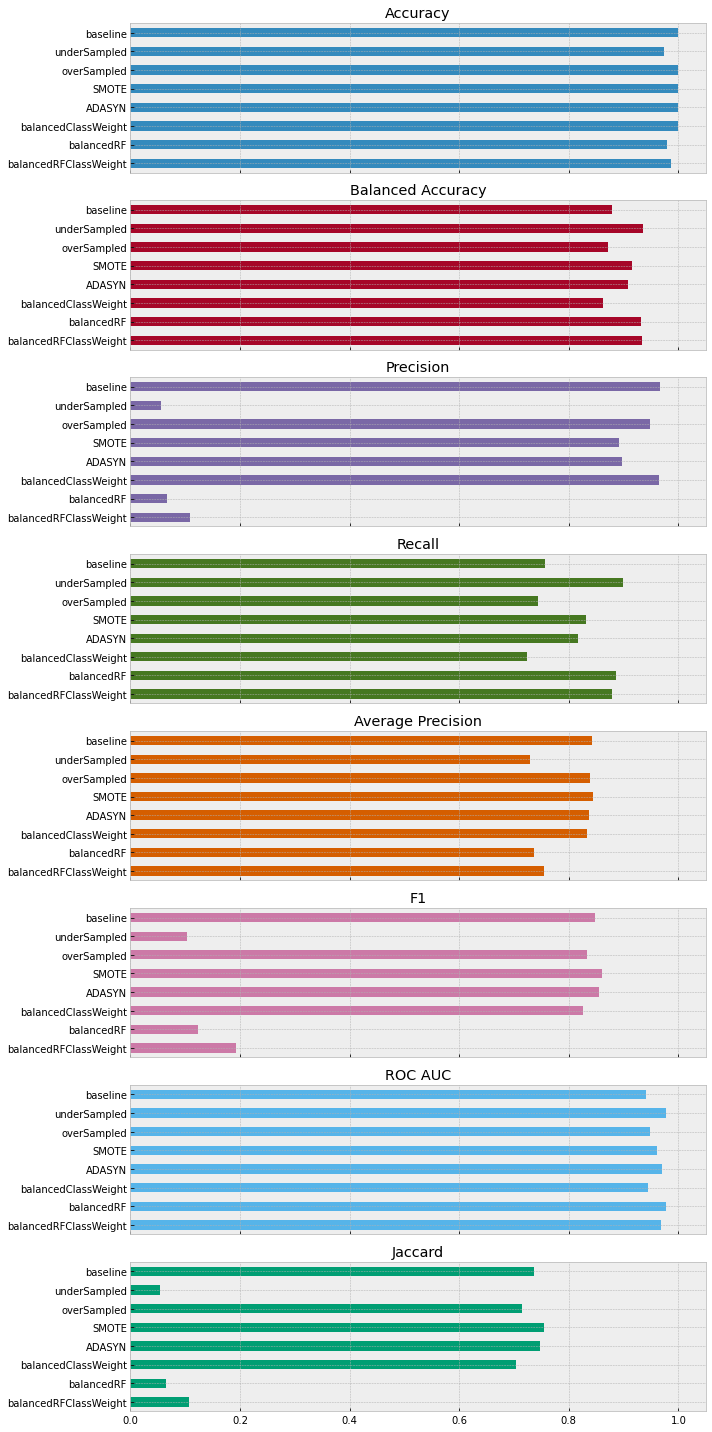

In [17]:
perf_df.T[::-1].plot(subplots=True, figsize=(10,20), kind='barh', legend=False)
plt.tight_layout()
plt.show()

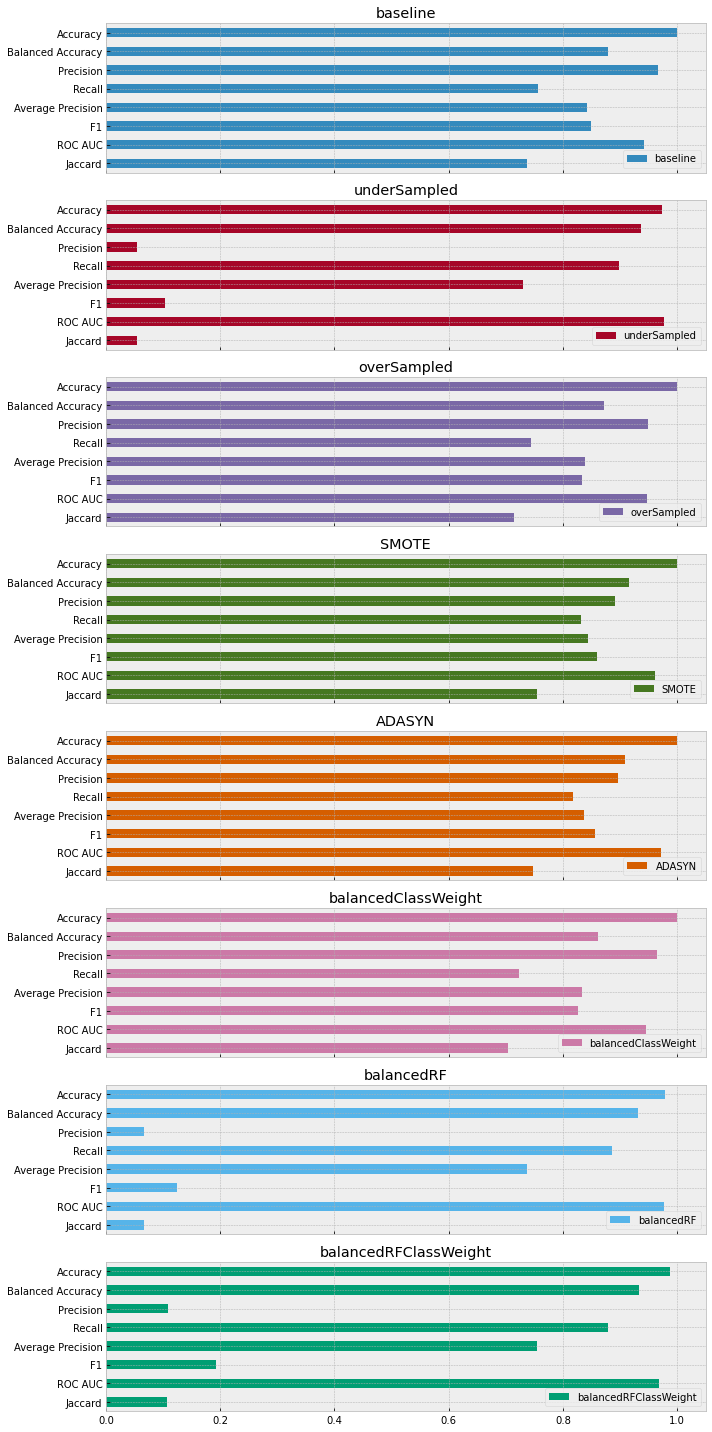

In [18]:
perf_df[::-1].plot(subplots=True, kind='barh', figsize=(10,20))
plt.tight_layout()
plt.show()